In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from spellmatch.assignment import assign
from spellmatch.benchmark.metrics import default_metrics
from spellmatch.io import read_image, read_mask, read_panel
from spellmatch.matching.algorithms.spellmatch import Spellmatch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
panel = read_panel("datasets/burger_windhager_2022/panel.csv").dropna(subset="name")
img = read_image("datasets/burger_windhager_2022/img.tiff", panel=panel, zscale=0.3)
mask = read_mask("datasets/burger_windhager_2022/mask.tiff", zscale=0.3)

In [4]:
algorithm = Spellmatch(
    intensity_transform="numpy.arcsinh",
    transform_estim_k_best=5,
    scores_tol=1e-9,
    filter_outliers=False,
    adj_radius=15,
    alpha=0.8,
    spatial_cdist_prior_thres=5,
    degree_weight=1,
    intensity_weight=1,
    intensity_interp_lmd=1,
    distance_weight=1,
)

In [5]:
infos = []
for z, (img1, img2, mask1, mask2) in enumerate(
    tqdm(zip(img[:-1], img[1:], mask[:-1], mask[1:]), total=img.shape[0] - 1)
):
    img1.name = "img1"
    img2.name = "img2"
    mask1.name = "mask1"
    mask2.name = "mask2"
    img1.attrs["scale"] = (1, 1)
    img2.attrs["scale"] = (1, 1)
    mask1.attrs["scale"] = (1, 1)
    mask2.attrs["scale"] = (1, 1)
    if len(np.unique(mask1)) > 5 and len(np.unique(mask2)) > 5:
        try:
            info, scores = algorithm.match_masks(mask1, mask2, img1, img2)
            if info["converged"]:
                scores_arr = scores.to_numpy()
                coords0 = scores.coords[scores.dims[0]].to_numpy()  # may contain duplicates
                coords1 = scores.coords[scores.dims[1]].to_numpy()  # may contain duplicates
                assignment_arr_true = np.zeros_like(scores_arr, dtype=bool)
                for c in np.unique(np.concatenate((coords0, coords1))):
                    assignment_arr_true[np.ix_(coords0 == c, coords1 == c)] = True
                assignment_mat = assign(scores, max_assignment=True, assignment_direction="intersect", as_matrix=True)
                assignment_arr_pred = assignment_mat.to_numpy()
                for metric_name, metric in default_metrics.items():
                    info[metric_name] = metric(scores_arr, assignment_arr_pred, assignment_arr_true)
                info["n1"], info["n2"] = assignment_arr_true.shape
                info["z"] = z
                infos.append(info)
        except Exception as e:
            logger.error(e)
results = pd.DataFrame(data=infos).drop(columns="lambda")
results.to_csv("validation.csv", index=False)

  0%|          | 0/129 [00:00<?, ?it/s]

ERROR - 2022-05-08 02:26:44,023 - 3691879161 - Input contains NaN, infinity or a value too large for dtype('float32').
ERROR - 2022-05-08 02:26:44,032 - 3691879161 - Input contains NaN, infinity or a value too large for dtype('float32').
WARNING - 2022-05-08 02:26:44,374 - _algorithms - Iterative algorithm did not converge after 50 iterations (0.186 seconds)
WARNING - 2022-05-08 02:26:45,055 - _algorithms - Iterative algorithm did not converge after 50 iterations (0.220 seconds)


In [6]:
results.describe()

,opt_iterations,iterations,precision,recall,f1score,uncertainty_mean,uncertainty_std,margin_mean,margin_std,entropy_mean,entropy_std,n1,n2,z
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,28.894737,3.131579,0.987246,0.986337,0.986642,0.431067,0.284940,0.441722,0.277355,0.496603,0.293873,10.394737,10.342105,52.815789
std,9.291687,0.442481,0.042728,0.051611,0.046362,0.111050,0.048715,0.112932,0.061390,0.179043,0.113034,3.183620,3.243671,26.076662
min,12.000000,3.000000,0.777778,0.714286,0.769231,0.165321,0.193923,0.214387,0.112534,0.011940,0.018335,5.000000,5.000000,10.000000
25%,20.000000,3.000000,1.000000,1.000000,1.000000,0.339937,0.251238,0.383549,0.231597,0.365905,0.218726,8.000000,8.000000,31.750000
50%,29.500000,3.000000,1.000000,1.000000,1.000000,0.459599,0.281807,0.418449,0.283099,0.516497,0.289612,11.000000,11.000000,51.500000
75%,37.000000,3.000000,1.000000,1.000000,1.000000,0.502348,0.317145,0.497047,0.316203,0.632105,0.386948,13.000000,13.000000,70.250000
max,44.000000,6.000000,1.000000,1.000000,1.000000,0.638933,0.404130,0.787964,0.424727,0.861241,0.526059,16.000000,16.000000,102.000000


/tmp/ipykernel_1364355/2773700746.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


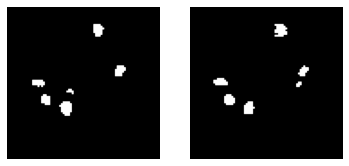

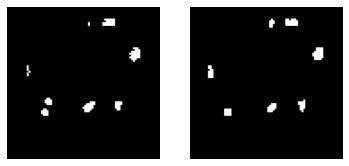

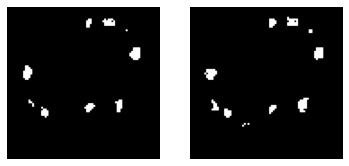

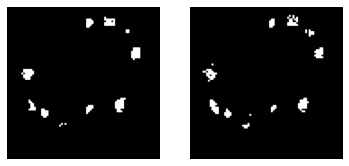

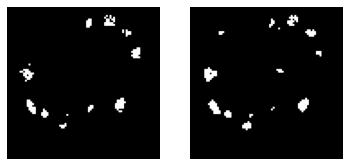

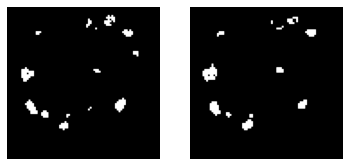

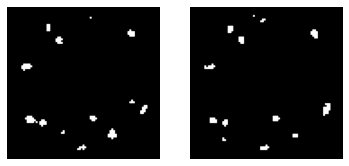

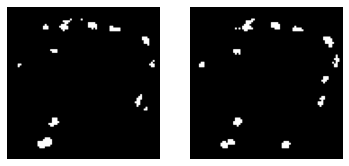

In [7]:
for z in results.loc[results["f1score"] != 1.0, "z"]:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(mask[z].to_numpy() != 0, cmap="Greys_r")
    axs[1].imshow(mask[z + 1].to_numpy() != 0, cmap="Greys_r")
    axs[0].axis("off")
    axs[1].axis("off")
    fig.show()